## インポートライブラリ

In [ ]:
import numpy as np 
import pandas as pd

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Google driveマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# パス設定

## 画像・モデルのパス指定


In [ ]:
IMAGE_PATH = '/content/drive/MyDrive/Drone_TA/Custum_Dataset/Car/JPEGImages/'
MASK_PATH = '/content/drive/MyDrive/Drone_TA/Custum_Dataset/Car/SegmentationClass/'

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/Drone_TA/PreTrain_Model/drone_Trained.pth'

## 学習モデルの保存先指定

In [ ]:
SAVE_PATH = '/content/drive/MyDrive/Drone_TA/Custum_Model/'

# データ設定

## データセットの分割

In [ ]:
def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('全画像数: ', len(df))

全画像数:  102


In [ ]:
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)#全データの10%をテストデータとしてランダムに分離
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)#全データの13.5%を検証データ,残りを訓練データとしてランダムに分離

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  77
Val Size     :  14
Test Size    :  11


## アノテーションの色の定義

In [ ]:
mapping = {(0, 0, 0): 0,
           (150, 143, 9): 1,
            }        

## 3次元アノテーションデータを2次元データに変換(mappingに定義されたRGB値からvalue値に変換)

In [ ]:
def convert_rgb_to_value(target):
  h = target.shape[0]#画像の高さの取得
  w = target.shape[1]#画像の横幅の取得
  target = target.permute(2,0,1).contiguous()#テンソルの形を変換(H,W,C)->(C,H,W)
  mask = torch.empty(h, w, dtype=torch.long)#(H,W)の2次元型を用意
  
  for k in mapping:#マップで定義したクラスの数繰り返し検出する
    idx = (target==torch.tensor(k, dtype=torch.uint8).unsqueeze(1).unsqueeze(2))#targetのある画素がmappingに定義し現在対象となっている値Kと一致すればTrueを返すテンソルidxを生成(C,H,W) 
                                                                                #(RGB値しか持たないtorch.tensor(k, dtype=torch.uint8)に対してunsueezeを2回行うことで比較可能な3次元形式に変形している)
    validx = (idx.sum(0) == 3)#validx:RGB値すべてが一致した場合True,一致しない場合Falseの2次元テンソル（H,W）
    mask[validx] = torch.tensor(mapping[k], dtype=torch.long)#validxがTrueだった場所に現在のKのRGB値を持つvalue値をmaskに代入
  
  return mask

## 学習時のデータセットの定義


In [ ]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std


    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png')
        filename = str(self.X[idx] + '.jpg')
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)

        mask = convert_rgb_to_value(mask)        
 
        return img, mask, filename
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

## データセットの変形(Data Augmentation)


In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

# データとモデルのロード

## 訓練データと検証データのロード

In [ ]:
batch_size= 4 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)    

## モデルのロード＆事前学習済みのパラメータのロード

In [ ]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=24, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

# 学習設定

## 検証時の精度評価関数の定義

In [ ]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

## 学習率の計算

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

## モデルの学習＆検証

In [ ]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles , filename = data

            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);

            #forward
            output = model(image)
            loss = criterion(output, mask)

            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)

            #backward
            loss.backward()
            optimizer.step() #update weight img = Image.fromarray(img)
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles ,filename = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model.state_dict(), SAVE_PATH + '/Unet-Mobilenet_v2_mIoU-{:.3f}.pth'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                #if not_improve == 7:
                    #print('Loss not decrease for 7 times, Stop Training')
                    #break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

## ハイパーパラメータ定義

In [ ]:
max_lr = 1e-3
epoch = 1
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

## 学習の実行とパラメータの保存

In [ ]:
history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

torch.save(model.state_dict(), SAVE_PATH + '/drone.pth')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 8.257 
Epoch:1/1.. Train Loss: 9.788.. Val Loss: 8.257.. Train mIoU:0.000.. Val mIoU: 0.000.. Train Acc:0.000.. Val Acc:0.000.. Time: 14.17m
Total time: 14.17 m


## 画像を一枚だけランダムに推論する

In [ ]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png')
        filename = str(self.X[idx])
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()

        mask = convert_rgb_to_value(mask)
        
        return img, mask, filename

In [ ]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [ ]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [ ]:
reverse_mapping = {1: (150, 143, 9),
                   2: (0, 0, 0),
                   3: (0, 0, 0),
                   4: (0, 0, 0),
                   5: (0, 0, 0),
                   6: (0, 0, 0),
                   7: (0, 0, 0),
                   8: (0, 0, 0),
                   9: (0, 0, 0),
                   10: (0, 0, 0),
                   11: (0, 0, 0),
                   12: (0, 0, 0),
                   13: (0, 0, 0),
                   14: (0, 0, 0),
                   15: (0, 0, 0),
                   16: (0, 0, 0),
                   17: (0, 0, 0),
                   18: (0, 0, 0),
                   19: (0, 0, 0),
                   20: (0, 0, 0),
                   21: (0, 0, 0),
                   22: (0, 0, 0),
                   23: (0, 0, 0),
                   0: (0, 0, 0),
            }      

In [ ]:
def visualize(temp):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0,len(reverse_mapping)):
        r[temp==l]=reverse_mapping[l][0]
        g[temp==l]=reverse_mapping[l][1]
        b[temp==l]=reverse_mapping[l][2]

    rgb = np.zeros((temp.shape[1], temp.shape[2],3))

    rgb[:,:,0] = (r)
    rgb[:,:,1] = (g)
    rgb[:,:,2] = (b)
    return rgb

DJI_0072


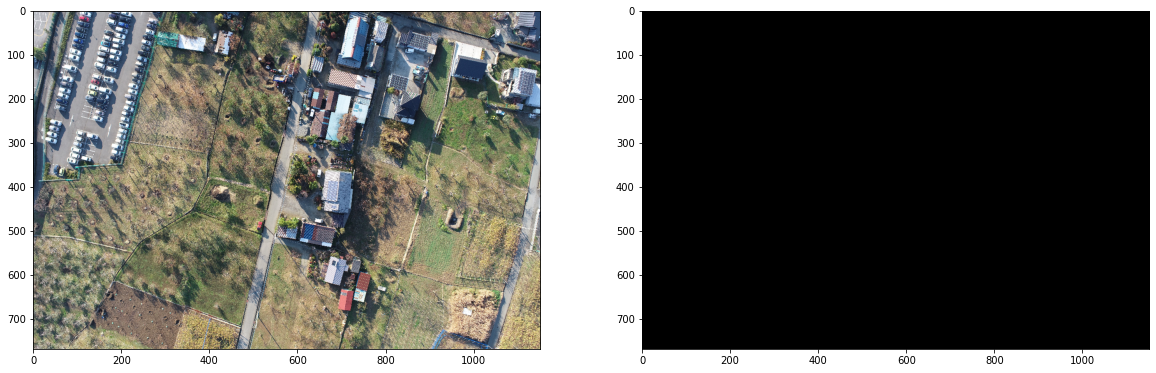

In [ ]:
import random

t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

index = random.randint(0, len(test_set))
img, mask, filename = test_set[index]
pred_mask, score = predict_image_mask_miou(model, img, mask)
pred_mask = pred_mask.cpu().numpy().copy()
pred_mask = pred_mask.reshape(1,pred_mask.shape[0],pred_mask.shape[1])
print(filename)


import matplotlib.pyplot as plt
plt.figure(figsize=(20,16))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(visualize(pred_mask))

## 任意の画像を一枚推論する

In [ ]:
def predict_image(model, image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    with torch.no_grad():
        image = image.unsqueeze(0)
        
        output = model(image)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked

In [ ]:
filepath = IMAGE_PATH + 'DJI_0075.jpg'
img = cv2.imread(filepath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

aug = t_test(image=img, mask=mask)
img = Image.fromarray(aug['image'])

pred_mask = predict_image(model, img)
pred_mask = pred_mask.cpu().numpy().copy()
pred_mask = pred_mask.reshape(1,pred_mask.shape[0],pred_mask.shape[1])

print(filename)

%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,16))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(visualize(pred_mask))